In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [3]:
import pickle

In [4]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
print(os.listdir("Data"))

['.DS_Store', 'test1', 'outliers', 'train']


In [6]:
#Constants
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [7]:
batch_size=18

In [8]:
filenames = os.listdir("Data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.shape

(25000, 2)

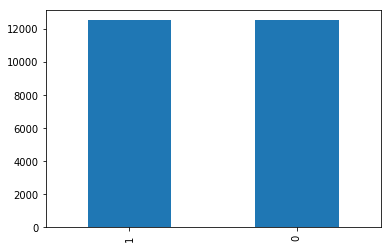

In [10]:
df['category'].value_counts().plot.bar()

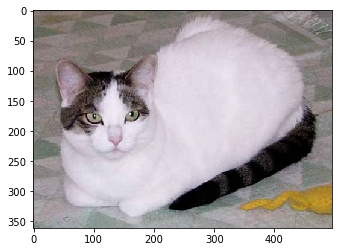

In [117]:
sample = random.choice(filenames)
image = load_img("Data/train/"+sample)
plt.imshow(image)

In [12]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [13]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Small Data Set Creation, Training and Testing

### Prepare Data

In [19]:
df_small = df[:2000]

In [20]:
df_small.shape

(2000, 2)

In [21]:
train_df, validate_df = train_test_split(df_small, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

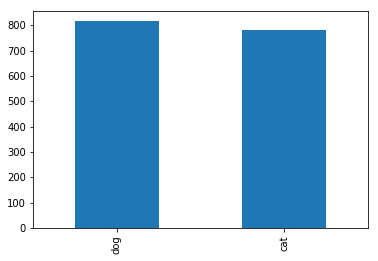

In [22]:
train_df['category'].value_counts().plot.bar()

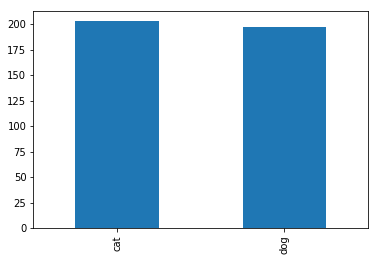

In [23]:
validate_df['category'].value_counts().plot.bar()

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 400 validated image filenames belonging to 2 classes.


### Model 1

In [27]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

W0903 15:33:51.951153 140735694447424 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 15:33:51.980922 140735694447424 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 15:33:51.992281 140735694447424 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 15:33:52.021572 140735694447424 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0903 15:33:52.022572 1407356944

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [28]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

W0903 15:33:54.137740 140735694447424 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
88/88 [==============================] - 77s 874ms/step - loss: 1.2987 - acc: 0.5676 - val_loss: 1.8144 - val_acc: 0.5505
Epoch 2/20
88/88 [==============================] - 73s 827ms/step - loss: 0.9809 - acc: 0.5936 - val_loss: 0.9655 - val_acc: 0.5969
Epoch 3/20
88/88 [==============================] - 67s 766ms/step - loss: 0.8742 - acc: 0.5803 - val_loss: 2.0057 - val_acc: 0.4738
Epoch 4/20
88/88 [==============================] - 68s 774ms/step - loss: 0.7536 - acc: 0.6055 - val_loss: 0.8994 - val_acc: 0.5707

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
88/88 [==============================] - 69s 786ms/step - loss: 0.6707 - acc: 0.6575 - val_loss: 0.7939 - val_acc: 0.5733
Epoch 6/20
88/88 [==============================] - 71s 812ms/step - loss: 0.6453 - acc: 0.6604 - val_loss: 0.6289 - val_acc: 0.6754
Epoch 7/20
88/88 [==============================] - 71s 807ms/step - loss: 0.6209 - acc: 0.6813 - val_loss: 0.6706 - val_

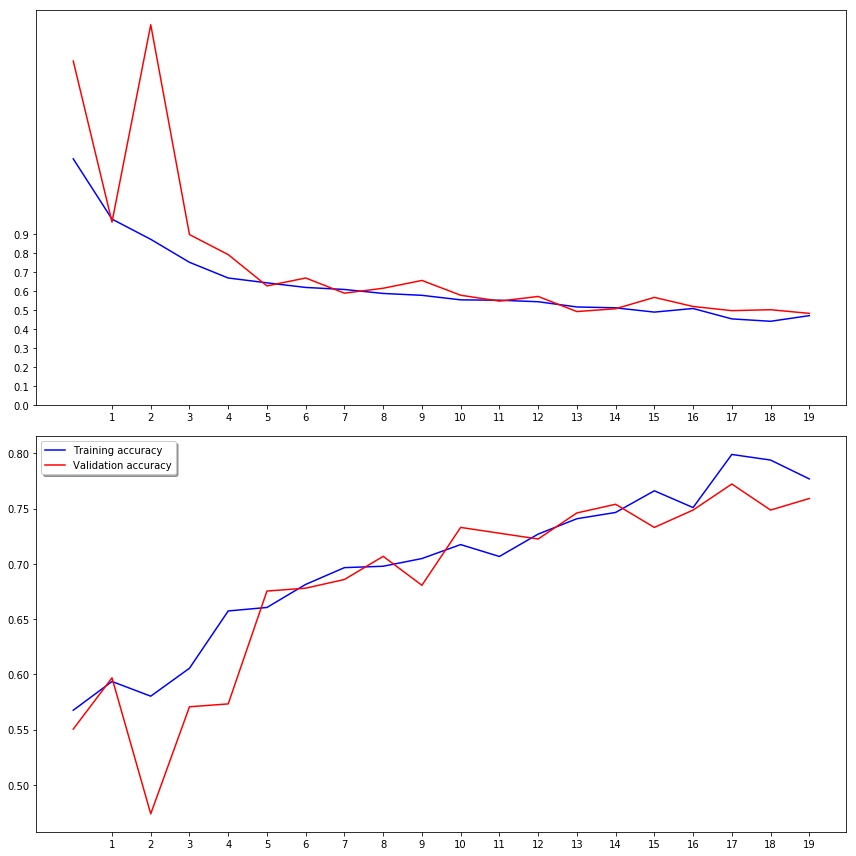

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

OUTLIER TESTING

In [35]:
test_filenames = os.listdir("Data/outliers")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [36]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/outliers/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5 validated image filenames.


In [37]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [38]:
results = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
results = pd.DataFrame(results).replace(label_map)

In [39]:
test_df.head()

,filename
0,km.jpg
1,pb.jpg
2,cr.jpg
3,dvdb.jpg
4,lm.jpg


In [40]:
results

,0
0,dog
1,dog
2,dog
3,dog
4,dog


### Model 2

In [118]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               65028608  
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
__________

In [42]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
88/88 [==============================] - 90s 1s/step - loss: 1.5524 - acc: 0.5751 - val_loss: 0.8890 - val_acc: 0.6204
Epoch 2/20
88/88 [==============================] - 86s 974ms/step - loss: 0.9338 - acc: 0.5810 - val_loss: 1.4756 - val_acc: 0.5157
Epoch 3/20
88/88 [==============================] - 85s 964ms/step - loss: 0.7925 - acc: 0.6145 - val_loss: 0.9043 - val_acc: 0.5864

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
88/88 [==============================] - 85s 963ms/step - loss: 0.6769 - acc: 0.6510 - val_loss: 0.8406 - val_acc: 0.6021
Epoch 5/20
88/88 [==============================] - 85s 965ms/step - loss: 0.6605 - acc: 0.6608 - val_loss: 0.7422 - val_acc: 0.5969

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/20
88/88 [==============================] - 84s 959ms/step - loss: 0.6001 - acc: 0.6929 - val_loss: 0.7243 - val_acc: 0.6099
Epoch 7/20
88/88 [=========================

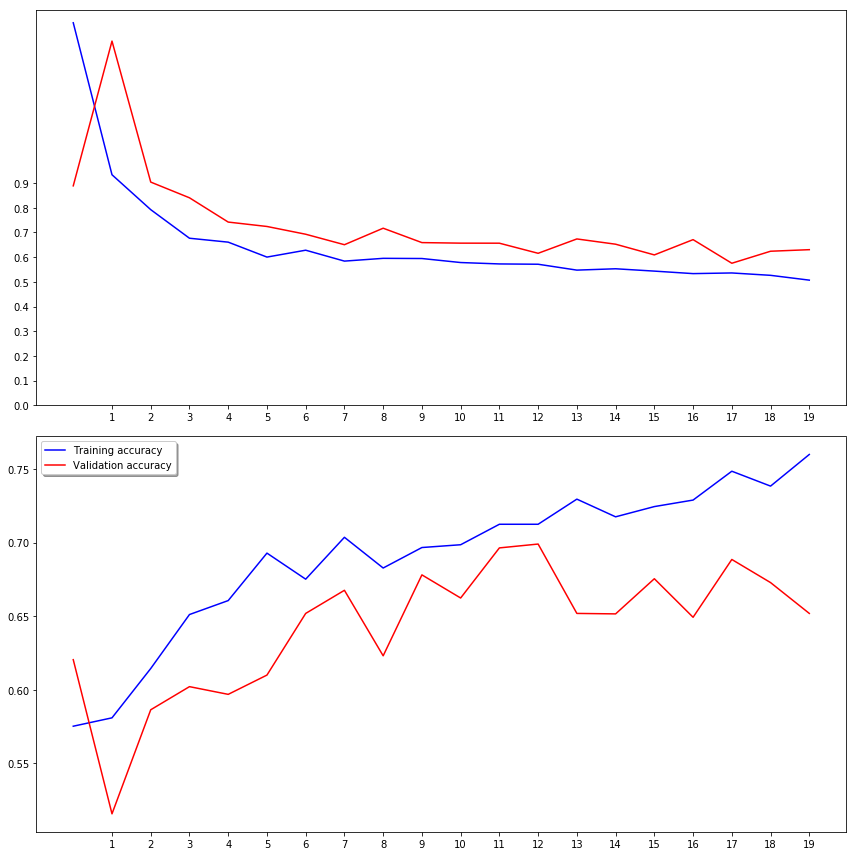

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

OUTLIER TESTING

In [49]:
test_filenames = os.listdir("Data/outliers")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [50]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/outliers/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5 validated image filenames.


In [51]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [52]:
results = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
results = pd.DataFrame(results).replace(label_map)

In [53]:
test_df.head()

,filename
0,km.jpg
1,pb.jpg
2,cr.jpg
3,dvdb.jpg
4,lm.jpg


In [54]:
results

,0
0,dog
1,dog
2,dog
3,dog
4,dog


# Big Data Set Creation, Training and Testing

### Prepare Data

In [120]:
df_big = df[3000:11000]

In [121]:
df_big.shape

(8000, 2)

In [122]:
train_df, validate_df = train_test_split(df_big, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

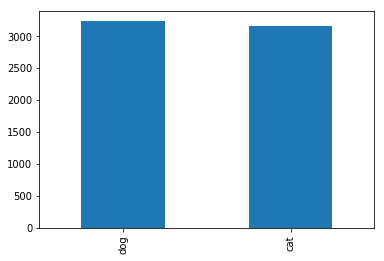

In [123]:
train_df['category'].value_counts().plot.bar()

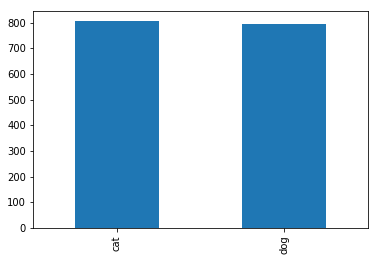

In [124]:
validate_df['category'].value_counts().plot.bar()

In [125]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [126]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6400 validated image filenames belonging to 2 classes.


In [127]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1600 validated image filenames belonging to 2 classes.


### Model 1

In [128]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
__________

In [129]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
355/355 [==============================] - 365s 1s/step - loss: 0.9490 - acc: 0.5889 - val_loss: 1.0803 - val_acc: 0.5234
Epoch 2/20
355/355 [==============================] - 404s 1s/step - loss: 0.6504 - acc: 0.6604 - val_loss: 0.7632 - val_acc: 0.6302
Epoch 3/20
355/355 [==============================] - 425s 1s/step - loss: 0.5852 - acc: 0.6993 - val_loss: 0.6003 - val_acc: 0.6814
Epoch 4/20
355/355 [==============================] - 404s 1s/step - loss: 0.5534 - acc: 0.7158 - val_loss: 1.8258 - val_acc: 0.5506
Epoch 5/20
355/355 [==============================] - 373s 1s/step - loss: 0.5209 - acc: 0.7492 - val_loss: 0.5102 - val_acc: 0.7522
Epoch 6/20
355/355 [==============================] - 421s 1s/step - loss: 0.4961 - acc: 0.7646 - val_loss: 1.5333 - val_acc: 0.5948
Epoch 7/20
355/355 [==============================] - 360s 1s/step - loss: 0.4850 - acc: 0.7715 - val_loss: 0.4718 - val_acc: 0.7604
Epoch 8/20
355/355 [==============================] - 301s 849ms/step

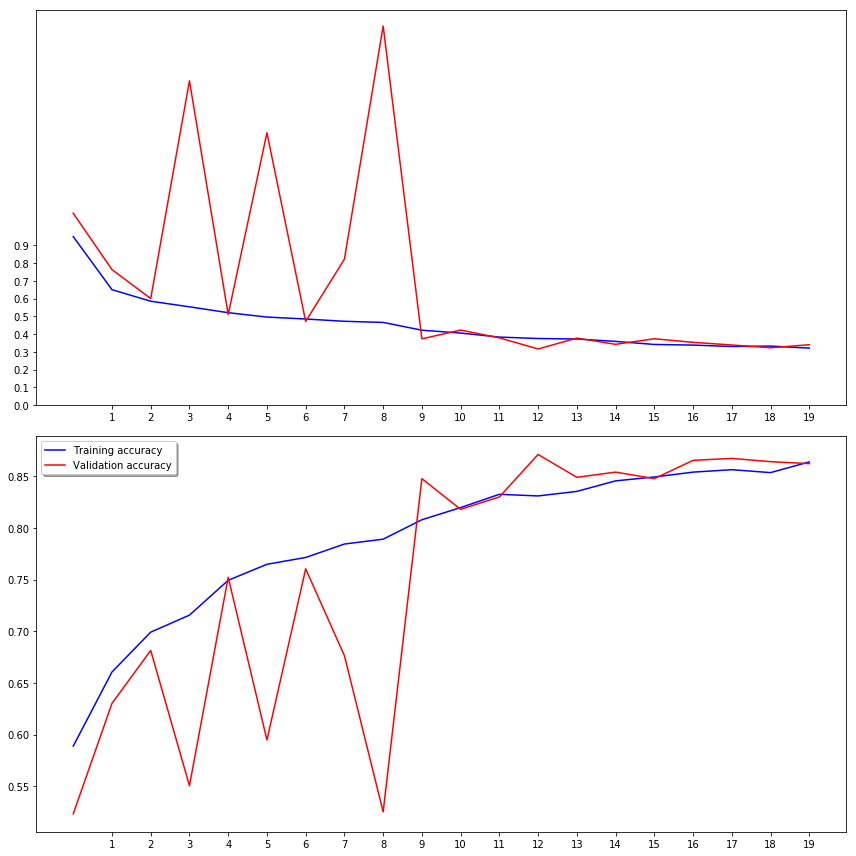

In [130]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

OUTLIER TESTING

In [131]:
test_filenames = os.listdir("Data/outliers")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [132]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/outliers/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5 validated image filenames.


In [133]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [134]:
results = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
results = pd.DataFrame(results).replace(label_map)

In [135]:
test_df.head()

,filename
0,km.jpg
1,pb.jpg
2,cr.jpg
3,dvdb.jpg
4,lm.jpg


In [136]:
results

,0
0,dog
1,dog
2,dog
3,dog
4,dog


### Model 2

In [101]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               65028608  
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
__________

In [102]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
355/355 [==============================] - 324s 913ms/step - loss: 0.9942 - acc: 0.5930 - val_loss: 0.7243 - val_acc: 0.6100
Epoch 2/20
355/355 [==============================] - 319s 900ms/step - loss: 0.6712 - acc: 0.6344 - val_loss: 0.6642 - val_acc: 0.6460
Epoch 3/20
355/355 [==============================] - 320s 903ms/step - loss: 0.6385 - acc: 0.6597 - val_loss: 0.6967 - val_acc: 0.6466
Epoch 4/20
355/355 [==============================] - 328s 923ms/step - loss: 0.6282 - acc: 0.6578 - val_loss: 0.6349 - val_acc: 0.6783
Epoch 5/20
355/355 [==============================] - 325s 916ms/step - loss: 0.6199 - acc: 0.6693 - val_loss: 0.7159 - val_acc: 0.6327
Epoch 6/20
355/355 [==============================] - 329s 926ms/step - loss: 0.6169 - acc: 0.6704 - val_loss: 0.6155 - val_acc: 0.6726

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
355/355 [==============================] - 330s 929ms/step - loss: 0.5804 - acc: 0.6954 - va

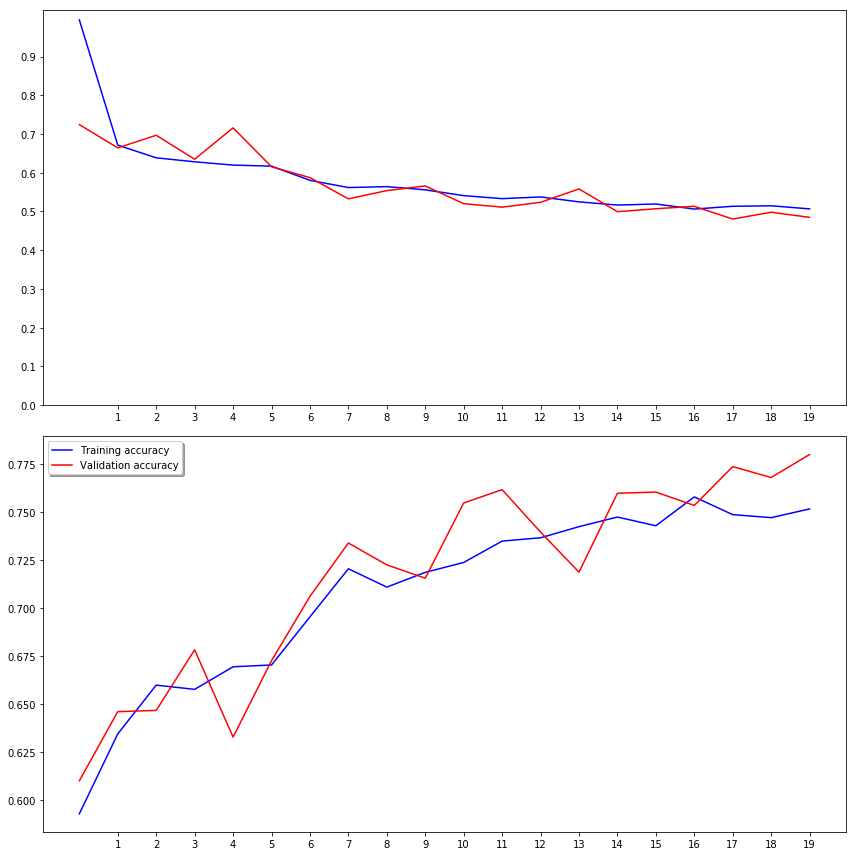

In [103]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

OUTLIER TESTING

In [108]:
pickle.dump(model, open("big_data_model2.p", "wb"))
model.save_weights("big_data_model2.h5")

In [109]:
test_filenames = os.listdir("Data/outliers")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [110]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Data/outliers/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5 validated image filenames.


In [111]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [112]:
results = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
results = pd.DataFrame(results).replace(label_map)

In [113]:
test_df.head()

,filename
0,km.jpg
1,pb.jpg
2,cr.jpg
3,dvdb.jpg
4,lm.jpg


In [114]:
results

,0
0,dog
1,dog
2,dog
3,dog
4,dog
